In [1]:
# windows-only, hopefully don't need to worry about endian
from struct import unpack, calcsize

class ProbeSettings:
    FORMAT_STR = 'iifiiiiif'
    
    def __init__(self, depth, frequency_idx, frequency, near_gain, mid_gain, far_gain, contrast, intensity, voltage):
        self.depth = depth
        self.frequency_idx = frequency_idx
        self.frequency = frequency
        self.near_gain = near_gain
        self.mid_gain = mid_gain
        self.far_gain = far_gain
        self.contrast = contrast
        self.intensity = intensity
        self.voltage = voltage
        
    def __str__(self):
        return  str(self.__class__) + '\n' + '\n'.join((str(item) + ' = ' + str(self.__dict__[item]) for item in sorted(self.__dict__)))    
    
class DownloadSettings:
    FORMAT_STR = 'i???' + ProbeSettings.FORMAT_STR + 'i??ii?ifi??ihi?ii'
    def __init__(self, probe_id, bidir, rf_probe, b360_probe, depth, frequency_idx, frequency, near_gain, mid_gain, far_gain, contrast, intensity, voltage, y_display_offset, img_left_orientation, img_top_orientation, image_rotation, frame_scan_rate, averaging, image_sector, scan_radius, compound_angle, compound_enabled, doubler_enabled, steering_angle, cine_compression_ratio, number_of_cine_frames, cine_cfm_mode, cfm_vectors, cfm_samples):
        self.probe_id = probe_id
        self.bidir = bidir
        self.rf_probe = rf_probe
        self.b360_probe = b360_probe
        self.probe_settings = ProbeSettings(depth, frequency_idx, frequency, near_gain, mid_gain, far_gain, contrast, intensity, voltage)
        self.y_display_offset = y_display_offset
        self.img_left_orientation = img_left_orientation
        self.img_top_orientation = img_top_orientation
        self.image_rotation = image_rotation
        self.frame_scan_rate = frame_scan_rate
        self.averaging = averaging
        self.image_sector = image_sector
        self.scan_radius = scan_radius
        self.compound_angle = compound_angle
        self.compound_enabled = compound_enabled
        self.doubler_enabled = doubler_enabled
        self.steering_angle = steering_angle
        self.cine_compression_ratio = cine_compression_ratio
        self.number_of_cine_frames = number_of_cine_frames
        self.cine_cfm_mode = cine_cfm_mode
        self.cmf_vectors = cfm_vectors
        self.cfm_samples = cfm_samples
    def __str__(self):
        return  str(self.__class__) + '\n' + '\n'.join((str(item) + ' = ' + str(self.__dict__[item]) for item in sorted(self.__dict__)))
    
def load_video(fp):
    with open(fp, mode='rb') as f:
        version = unpack('i', f.read(calcsize('i')))
        download_settings = DownloadSettings(*unpack(DownloadSettings.FORMAT_STR, f.read(calcsize(DownloadSettings.FORMAT_STR))))
        tmp_buffer = f.read(1164)
        length = 127 * 1024 * download_settings.number_of_cine_frames
        cine_buffer = bytearray(f.read(length))
        
        cfm_cine_length = None
        cfm_cine_buffer = None
        if download_settings.cine_cfm_mode:
            cfm_cine_length = download_settings.number_of_cine_frames * download_settings.cfm_vectors * download_settings.cfm_samples
            cfm_cine_buffer = f.read(cfm_cine_length)
    
    return version, download_settings, tmp_buffer, length, cine_buffer, cfm_cine_length, cfm_cine_buffer
        


In [2]:
result = load_video('C:\\Users\\brad.moore\\Desktop\\test1.cine')

In [4]:
import itk

In [5]:
size = (127, 1024, result[1].number_of_cine_frames)
img = itk.Image[itk.UC, 3].New()

In [6]:
img.SetRegions(itk.ImageRegion[3](size))
img.Allocate()

In [7]:
import ctypes
c_ptr = img.GetBufferPointer()

In [8]:
c_tmp_buffer = ctypes.c_uint8 * (size[0] * size[1] * size[2])

In [9]:
c_buffer = c_tmp_buffer.from_buffer(result[4])

In [10]:
ctypes.memmove(ctypes.c_void_p(int(c_ptr)), c_buffer, size[0] * size[1] * size[2])

2709700128864

In [11]:
type(c_ptr)

SwigPyObject

In [12]:
itk.Index.GetTypes()

<itkTemplate itk::Index>
Options:
  [1,]
  [2,]
  [3,]
  [4,]
  [5,]


In [13]:
def write_to_image(img, input_array):
    size = list(img.GetLargestPossibleRegion().GetSize())
    p = 0
    idx = itk.Index[3]()
    idx_map = [2, 0, 1]
    for i in range(size[idx_map[0]]):
        idx.SetElement(idx_map[0], i)
        for j in range(size[idx_map[1]]):
            idx.SetElement(idx_map[1], j)
            for k in range(size[idx_map[2]]):
                idx.SetElement(idx_map[2], k)
                img.SetPixel(idx, input_array[p])
                p += 1


In [ ]:
print(len(result[4]))
print(img)


In [15]:
write_to_image(img, result[4])

In [24]:
print(img)

Image (00000276E5AB5430)
  RTTI typeinfo:   class itk::Image<unsigned char,3>
  Reference Count: 1
  Modified Time: 4
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [127, 1024, 128]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [127, 1024, 128]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [127, 1024, 128]
  Spacing: [1, 1, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1 0 0
0 1 0
0 0 1

  PointToIndexMatrix: 
1 0 0
0 1 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (00000276C9E43260)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,unsigned char>
      Reference Count: 1
      Modified T

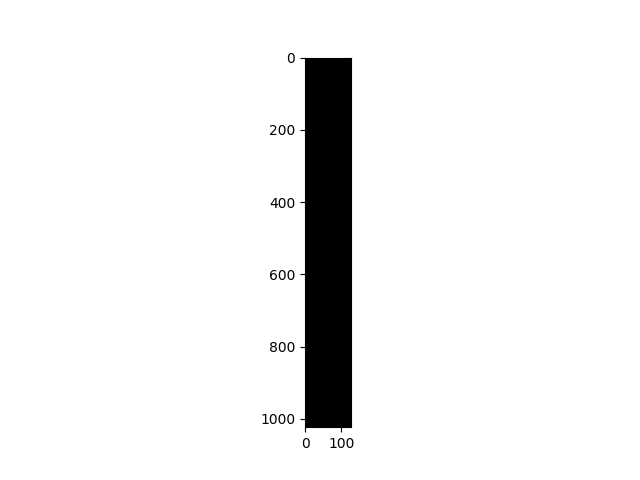

In [29]:
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import interact

@interact(x=(0, npimg.shape[2]-1,1))
def foo(x=0):
    plt.imshow(img[x,:,:], cmap='gray')